# Clustering via K-means and spherical K-means

Clustering refers to the unsupervised techniques of identifying clusters of observations that are "similar" to each other. In this project we will examine the *K-means* and *spherical K-means* algorithms using data from John Foreman's book "Data Smart." While K-means is simple to implement and efficient, we will see that spherical K-means is particularly appropriate for market basket analysis. 


## K-means clustering algorithm

K-means clustering is an algorithm for partitioning the dataset into distinct, non-overlapping clusters by minimizing the within-cluster variance. Within-cluster variance can be expressed as the sum of the pairwise squared Euclidean distances between each pair of points within the cluster.  

Deriving the optimal partition of observations into clusters with minimum within-cluster variance can be analytically intractable unless the number of clusters and number of observations are very small. Therefore, the K-means algorithm can be used to find a local optmium that minimizes the within-cluster variance assuming that the number of clusters is fixed and defined at the onset. The algorithm uses the concept of a cluster centroid, which is the vector of feature means for the observations in the cluster. It can be shown that the optimization problem of minimizing the sum of pairwise distances over *k* clusters is equivalent to finding the cluster centroids that minimize the distance of each point in the cluster to that cluster's centroid (all distances are Euclidean distances). The basic K-means algorithm operates as follows:

1. Define number of clusters
2. Randomly assign each observation to a cluster
3. Iterate the below until no observation is reassigned to a different cluster

    a. Compute the cluster centroid for each cluster
    
    b. Calculate the distance between each observation and the cluster centroids
    
    c. Assign the observation to the closest cluster centroid

The K-means algorithm finds a local optimum, which is dependent on the initialized clusters in Step 2. There a number of different initialization approaches that increase the chances of finding an optimum close to the global optimum. A couple of common ones are: 

*  Using random initialization of the clusters, run the algorithm more than once and select the local optimum that results in the lowest within-cluster variance. This selection process is built into R's *kmeans* function. 

*  Choose the initial cluster centroids to be as far from each other as possible - this is known as kmeans++ and can be implemented via the *flexclust* package.


*Caveats*

* Clusters may not be robust to changes in the data (e.g., removing a subset of observations or using a new sample altogether). 

* Clusters that emerge may be influenced by outlier observations (i.e., observations that really do not belong to any of the clusters but the algorithm forces a cluster assignment on them, which skews the centroids).

* K-means would not perform well if the inherent clusters are of different sizes, if they are not spherical, or if they overlap. 



*References:*

* Data Smart by John Foreman
* Coursera: Machine Learning: Clustering & Retrieval, University of Washington
* Introduction to Statistical Learning by James, Witten, Hastie, and Tibshirani
* Mining of Massive Datasets by Leskovec, Rajaraman, and Ullman
* Selecting the right objective measure for association analysis by Tan, Kumar, and Srivastava (2004)
* Online references: 

http://www.statmethods.net/advstats/cluster.html 

http://disi.unitn.it/~themis/courses/MassiveDataAnalytics/slides/Clustering2-2in1.pdf  

http://cran.cnr.berkeley.edu/web/views/Cluster.html  

http://stackoverflow.com/questions/15376075/cluster-analysis-in-r-determine-the-optimal-number-of-clusters/15376462#15376462 

http://www.sthda.com/english/wiki/determining-the-optimal-number-of-clusters-3-must-known-methods-unsupervised-machine-learning#three-popular-methods-for-determining-the-optimal-number-of-clusters 

*Data source:* 

*wine.csv* dataset from Chapter 2 of Data Smart by John Foreman  
http://www.wiley.com/WileyCDA/WileyTitle/productCd-111866146X.html  

## Load and examine the data

We will use a data set from Chapter 2 of the "Data Smart" book by J. Foreman. The dataset has information about 32 wine deals that a merchant has offered in the past year. The deals were advertised in the merchant's monthly newsletter. The goal of the analysis is to use purchase history data about 100 customers and segment these customers into a small number of clusters such that the merchant can send a tailored newsletter to each group of customers. 

The data was provided as an Excel file with a number of tabs. We will use the "Matrix" tab, which has 32 rows representing the various wine offers by a merchant. The columns store information about:

1. Offer - the deal id (1 - 32)
2. Campaign - the month in which the deal was offered
3. Varietal - type of wine advertised in the offer (e.g., Malbec, Champagne, etc.)
4. Minimum Qty (kg) - minimum quantity required
5. Discount (%) -  discount applied
6. Origin - country of origin of the wine
7. Past peak - True/False variable for whether the wine has passed its peak
8. Columns 8 through 107 are labeled with the names of each customer who received the newsletters last year. The column values are binary 0/1 variables, where 1 indicates that the customer has taken the offer and 0 otherwise. 

In [2]:
# Load the variable names data
# Load the wine data
wine_raw <- read.csv("~/Study projects/Clustering/wineKMC.csv", header=TRUE, stringsAsFactors=FALSE)
paste('There are ', dim(wine_raw)[1], 'observations and ', dim(wine_raw)[2], 'variables')
if (dim(wine_raw)[1] != 32 | dim(wine_raw)[2]!=107) {
    print("Check data load - number of observations or variables is not as expected")
} else {
        print("Data is loaded correctly")
} 
head(wine_raw)

[1] "There are  32 observations and  107 variables"

[1] "Data is loaded correctly"


Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak,Adams,Allen,Anderson,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
1,January,Malbec,72,56,France,FALSE,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,1,NA,NA
2,January,Pinot Noir,72,17,France,FALSE,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,February,Espumante,144,32,Oregon,TRUE,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,February,Champagne,72,48,France,TRUE,NA,NA,NA,...,1,NA,1,NA,NA,NA,NA,NA,1,NA
5,February,Cabernet Sauvignon,144,44,New Zealand,TRUE,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,March,Prosecco,144,86,Chile,FALSE,NA,NA,NA,...,1,NA,NA,NA,NA,NA,NA,NA,1,1


The 0 values in columns 8-107 were read in as "NA", so we will replace them with 0. 

In [3]:
# Replace NAs in the customer columns with 0s
wine_raw[ ,c(8:107)][is.na(wine_raw[ ,c(8:107)])] <- 0
head(wine_raw)

Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak,Adams,Allen,Anderson,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
1,January,Malbec,72,56,France,FALSE,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,January,Pinot Noir,72,17,France,FALSE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,February,Espumante,144,32,Oregon,TRUE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,February,Champagne,72,48,France,TRUE,0,0,0,...,1,0,1,0,0,0,0,0,1,0
5,February,Cabernet Sauvignon,144,44,New Zealand,TRUE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,March,Prosecco,144,86,Chile,FALSE,0,0,0,...,1,0,0,0,0,0,0,0,1,1


For purposes of the clustering analysis, the rows should contain information about the various observations (i.e., customers) and the columns should contain the features (i.e., wheather a purchase was made or not for each offer). Therefore, we will transform the dataset to 1) extract only the offer id column and the customer name columns, and 2) transpose the dataframe such that the offer id's become column labels and each customer's purchase history is stored in a row. 

In [4]:
offerid <- paste("offer", wine_raw[ ,1], sep="")
wine <- t(wine_raw[ ,c(8:107)])
wine <- data.frame(wine)
colnames(wine) <- offerid
head(wine)
summary(wine)

,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,offer10,...,offer23,offer24,offer25,offer26,offer27,offer28,offer29,offer30,offer31,offer32
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
Barnes,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


     offer1        offer2        offer3         offer4         offer5    
 Min.   :0.0   Min.   :0.0   Min.   :0.00   Min.   :0.00   Min.   :0.00  
 1st Qu.:0.0   1st Qu.:0.0   1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.00  
 Median :0.0   Median :0.0   Median :0.00   Median :0.00   Median :0.00  
 Mean   :0.1   Mean   :0.1   Mean   :0.06   Mean   :0.12   Mean   :0.04  
 3rd Qu.:0.0   3rd Qu.:0.0   3rd Qu.:0.00   3rd Qu.:0.00   3rd Qu.:0.00  
 Max.   :1.0   Max.   :1.0   Max.   :1.00   Max.   :1.00   Max.   :1.00  
     offer6         offer7         offer8        offer9       offer10    
 Min.   :0.00   Min.   :0.00   Min.   :0.0   Min.   :0.0   Min.   :0.00  
 1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.0   1st Qu.:0.0   1st Qu.:0.00  
 Median :0.00   Median :0.00   Median :0.0   Median :0.0   Median :0.00  
 Mean   :0.12   Mean   :0.19   Mean   :0.2   Mean   :0.1   Mean   :0.07  
 3rd Qu.:0.00   3rd Qu.:0.00   3rd Qu.:0.0   3rd Qu.:0.0   3rd Qu.:0.00  
 Max.   :1.00   Max.   :1.00   Max.   

From the summary statistics above, we see that purchase data is encoded as a numeric variable, the medians are equal to 0 and the means are close to 0, suggesting that the purchase data is fairly sparse (i.e., there are only a few purchases made by each customer). 

Also, since the features are binary 0-1 variables indicating if a purchase has been made, we do not have to standardize the data (a necessary step when working with data measured on different scales, e.g., if we also had columns with demographic data about the customers). 

Since interpreting and visualizing clusters in two dimension is much easier than in p-dimensional space, we will check to see if the data can be reduced to two dimensations that explain a good chunk of the total variation. For this, we will apply Principal Component Analysis. 

In [5]:
# Apply PCA
pc <-prcomp(wine, scale=FALSE)
summary(pc)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.6400 0.5546 0.44977 0.40870 0.38750 0.37873 0.37174
Proportion of Variance 0.1439 0.1080 0.07104 0.05866 0.05273 0.05037 0.04853
Cumulative Proportion  0.1439 0.2519 0.32291 0.38157 0.43430 0.48468 0.53321
                           PC8     PC9    PC10   PC11    PC12    PC13    PC14
Standard deviation     0.34917 0.34112 0.32870 0.3152 0.30816 0.29479 0.26938
Proportion of Variance 0.04282 0.04086 0.03794 0.0349 0.03335 0.03052 0.02548
Cumulative Proportion  0.57602 0.61689 0.65483 0.6897 0.72308 0.75360 0.77909
                          PC15    PC16    PC17    PC18    PC19    PC20   PC21
Standard deviation     0.25710 0.24991 0.23737 0.23081 0.21746 0.20962 0.1975
Proportion of Variance 0.02321 0.02193 0.01979 0.01871 0.01661 0.01543 0.0137
Cumulative Proportion  0.80230 0.82423 0.84402 0.86273 0.87934 0.89477 0.9085
                          PC22    PC23    

In [6]:
# How many principal components does it take to explain at least 80% of the variation:
which(summary(pc)$importance[3,] > 0.8)[1]

PC15 
  15

The first two principal components explain about 25% of the total variation in the data and it takes 15 principal components to explain at least 80% of the variance. Therefore, PCA cannot help us reduce the data to two dimensitions without significant loss of information. We will proceed with the original set of dimensions. 

## Application of K-Means clustering with random cluster initialization

Since we are looking to create targeted offers to a small group of customers, we will start with a small number of clusters, such as 4. 

In [7]:
# Set seed because the initialization stage is random 
set.seed(14)
# Set nstart=20 to run the k-means algorithm 20 times with different random intialization of the clusters each time
kmeans.out <- kmeans(wine, 4, nstart=20)
# Summarize output
kmeans.out
paste("The total within-cluster variance is: ", kmeans.out$tot.withinss)

K-means clustering with 4 clusters of sizes 20, 32, 16, 32

Cluster means:
  offer1 offer2  offer3  offer4 offer5  offer6 offer7  offer8  offer9 offer10
1 0.0500  0.000 0.25000 0.25000  0.000 0.55000 0.2500 0.20000 0.05000  0.3000
2 0.2500  0.125 0.03125 0.21875  0.125 0.03125 0.0000 0.03125 0.28125  0.0000
3 0.0625  0.375 0.00000 0.00000  0.000 0.00000 0.0000 0.00000 0.00000  0.0625
4 0.0000  0.000 0.00000 0.00000  0.000 0.00000 0.4375 0.46875 0.00000  0.0000
  offer11 offer12 offer13 offer14 offer15 offer16 offer17 offer18 offer19
1 0.00000 0.00000  0.0000  0.1500   0.100  0.0000  0.0000   0.100    0.25
2 0.40625 0.09375  0.0000  0.1875   0.125  0.1250  0.0000   0.000    0.00
3 0.00000 0.06250  0.0000  0.0000   0.000  0.0625  0.4375   0.000    0.00
4 0.00000 0.03125  0.1875  0.0000   0.000  0.0000  0.0000   0.375    0.00
  offer20 offer21 offer22 offer23 offer24 offer25 offer26 offer27 offer28
1 0.05000 0.15000   0.450  0.1000    0.00  0.0000 0.00000 0.20000 0.00000
2 0.15625 0.00000

[1] "The total within-cluster variance is:  213.075"

The ratio of "between sum-of-squares" and "total sum-of-squares" is somewhat small (24%) indicating that the separation into clusters is not particularly good. 

In [8]:
# Review the cluster assignments 
km.clusters <- kmeans.out$cluster
km.clusters

Adams      Allen   Anderson     Bailey      Baker     Barnes       Bell 
         4          2          3          4          1          1          3 
   Bennett     Brooks      Brown     Butler   Campbell     Carter      Clark 
         4          2          4          2          3          4          2 
   Collins       Cook     Cooper        Cox       Cruz      Davis       Diaz 
         2          3          2          3          4          2          4 
   Edwards      Evans     Fisher     Flores     Foster     Garcia      Gomez 
         4          2          2          3          2          2          2 
  Gonzalez       Gray      Green  Gutierrez       Hall     Harris  Hernandez 
         2          3          4          1          2          1          4 
      Hill     Howard     Hughes    Jackson      James    Jenkins    Johnson 
         4          2          4          2          4          3          3 
     Jones      Kelly       King        Lee      Lewis       Long      Lopez 
         4          1          4          1          4          1          2 
    Martin   Martinez     Miller   Mitchell      Moore    Morales     Morgan 
         2          2          1          2          3          1          4 
    Morris     Murphy      Myers     Nelson     Nguyen      Ortiz     Parker 
         3          4          4          1          1          4          2 
     Perez      Perry   Peterson   Phillips     Powell      Price    Ramirez 
         4          4          3          3          2          2          2 
      Reed      Reyes Richardson     Rivera    Roberts   Robinson  Rodriguez 
         2          2          1          4          1          4          3 
    Rogers       Ross    Russell    Sanchez    Sanders      Scott      Smith 
         1          4          3          2          2          1          3 
   Stewart   Sullivan     Taylor     Thomas   Thompson     Torres     Turner 
         4          4          4          2          2          4          1 
    Walker       Ward     Watson      White   Williams     Wilson       Wood 
         4          2          4          2          1          4          1 
    Wright      Young 
         1          1

### Interpreting the clusters
How can we interpret the clusters in this p-dimensional space? We can display the cluster centroids and look at which feature means are close to 1 vs 0. Features means closer to 1 indicate that a larger number of people purchased this offer, while features means close to 0 indicate low demand for this offer. 

We will first examine cluster 1 by sorting the vector elements of its cluster centroid in descenting order:

In [9]:
# Display the feature dimensions of the cluster centroids
df.centers <- data.frame(t(kmeans.out$centers))
colnames(df.centers) <- paste0("cluster", c(1:4))
df.centers[order(-df.centers[1]), ]

,cluster1,cluster2,cluster3,cluster4
offer31,0.60,0.15625,0.0000,0.00000
offer6,0.55,0.03125,0.0000,0.00000
offer22,0.45,0.37500,0.0000,0.00000
offer10,0.30,0.00000,0.0625,0.00000
offer3,0.25,0.03125,0.0000,0.00000
offer4,0.25,0.21875,0.0000,0.00000
offer7,0.25,0.00000,0.0000,0.43750
offer19,0.25,0.00000,0.0000,0.00000
offer8,0.20,0.03125,0.0000,0.46875
offer27,0.20,0.09375,0.0625,0.03125


Cluster 1 exhibits preference for the following offers: 31, 6, 22, 10, 3, 4, 19, 27, 21, 23, and 32. It has the highest number of purchases of these offers. Let's look at the characteristics of the first 10 of these offers:

In [10]:
wine_desc <- wine_raw[ ,1:7]
cluster1_top10 <- c(31, 6, 22, 10, 3, 4, 18, 27, 21, 23)
wine_desc[cluster1_top10, ]

,Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak
31,31,December,Champagne,72,89,France,FALSE
6,6,March,Prosecco,144,86,Chile,FALSE
22,22,August,Champagne,72,63,France,FALSE
10,10,April,Prosecco,72,52,California,FALSE
3,3,February,Espumante,144,32,Oregon,TRUE
4,4,February,Champagne,72,48,France,TRUE
18,18,July,Espumante,6,50,Oregon,FALSE
27,27,October,Champagne,72,88,New Zealand,FALSE
21,21,August,Champagne,12,50,California,FALSE
23,23,September,Chardonnay,144,39,South Africa,FALSE


Looking at the descriptions above, we see the following similarities among the top 10 deals purchased in Cluster 1:

1.  9 out of the 10 wine varieties are sparkling wines
2.  Demand for sparkling wine was (unsurprisingly) highest in December - 60% of the customers in cluster 1 purchased offer 31.  
3.  8 out of 10 wines are not past their peak

Let's see if we can observe other patterns in cluster 3 (since the order of clusters does not matter, we could have picked any of the other clusters to examine next):

In [11]:
df.centers[order(-df.centers[3]), ]

,cluster1,cluster2,cluster3,cluster4
offer24,0.00,0.00000,0.7500,0.00000
offer26,0.00,0.09375,0.7500,0.00000
offer17,0.00,0.00000,0.4375,0.00000
offer2,0.00,0.12500,0.3750,0.00000
offer1,0.05,0.25000,0.0625,0.00000
offer10,0.30,0.00000,0.0625,0.00000
offer12,0.00,0.09375,0.0625,0.03125
offer16,0.00,0.12500,0.0625,0.00000
offer23,0.10,0.06250,0.0625,0.00000
offer27,0.20,0.09375,0.0625,0.03125


We could write a function that selects the offers that have their highest mean within a cluster relative to the other clusters, but for now we will examine the above table visually. There are only 4 offers that dominated purchases in cluster 3:
24, 26, 17, 2

In [12]:
cluster3_top10 <- c(24, 26, 17, 2)
wine_desc[cluster3_top10, ]

,Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak
24,24,September,Pinot Noir,6,34,Italy,FALSE
26,26,October,Pinot Noir,144,83,Australia,FALSE
17,17,July,Pinot Noir,12,47,Germany,FALSE
2,2,January,Pinot Noir,72,17,France,FALSE


Cluster 3 seems to be for the Pinot Noir lovers! But before we conclude that, let's confirm that Pinot Noir is not overly represented in the sample:

In [13]:
length(wine_desc[wine_desc$Varietal=="Pinot Noir", ])

[1] 7

Since only seven of the offers featured Pinot Noir and cluster 3 captured four of these offers, we can be more confident that this cluster captures customers with a strong preference for Pinot Noir. 

Next we will examine clusters 2 and 4:

In [14]:
df.centers[order(-df.centers[2]), ]

,cluster1,cluster2,cluster3,cluster4
offer11,0.00,0.40625,0.0000,0.00000
offer22,0.45,0.37500,0.0000,0.00000
offer9,0.05,0.28125,0.0000,0.00000
offer1,0.05,0.25000,0.0625,0.00000
offer4,0.25,0.21875,0.0000,0.00000
offer14,0.15,0.18750,0.0000,0.00000
offer25,0.00,0.18750,0.0000,0.00000
offer30,0.00,0.18750,0.0000,0.50000
offer20,0.05,0.15625,0.0000,0.00000
offer28,0.00,0.15625,0.0000,0.03125


In [15]:
cluster2_top10 <- c(11,9,1,14,25,30,20, 28, 5, 15)
wine_desc[cluster2_top10, ]

,Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak
11,11,May,Champagne,72,85,France,FALSE
9,9,April,Chardonnay,144,57,Chile,FALSE
1,1,January,Malbec,72,56,France,FALSE
14,14,June,Merlot,72,64,Chile,FALSE
25,25,October,Cabernet Sauvignon,72,59,Oregon,TRUE
30,30,December,Malbec,6,54,France,FALSE
20,20,August,Cabernet Sauvignon,72,82,Italy,FALSE
28,28,November,Cabernet Sauvignon,12,56,France,TRUE
5,5,February,Cabernet Sauvignon,144,44,New Zealand,TRUE
15,15,June,Cabernet Sauvignon,144,19,Italy,FALSE


Cluster 2 is hard to interpret by just looking at the qualitative features. Let's look at the average characteristics of the qunatitative features to gain more insight. 

In [16]:
summary(wine_desc)

    Offer..        Campaign           Varietal         Minimum.Qty..kg.
 Min.   : 1.00   Length:32          Length:32          Min.   :  6.00  
 1st Qu.: 8.75   Class :character   Class :character   1st Qu.: 12.00  
 Median :16.50   Mode  :character   Mode  :character   Median : 72.00  
 Mean   :16.50                                         Mean   : 65.81  
 3rd Qu.:24.25                                         3rd Qu.: 72.00  
 Max.   :32.00                                         Max.   :144.00  
  Discount....      Origin          Past.Peak      
 Min.   :17.00   Length:32          Mode :logical  
 1st Qu.:44.75   Class :character   FALSE:25       
 Median :55.00   Mode  :character   TRUE :7        
 Mean   :57.84                      NA's :0        
 3rd Qu.:82.25                                     
 Max.   :89.00                                     

It looks like cluster 2 has identified customers who prefer purchasing high volumes at steeper discounts - 8 of the 10 offers require minimum purchased quantity in the upper quartile (72 and above) and 7 of the 10 offers offer discounts of at least 55, which is the median discount for all offers. 

Next, we look at cluster 4:

In [17]:
df.centers[order(-df.centers[4]), ]

,cluster1,cluster2,cluster3,cluster4
offer29,0.00,0.03125,0.0000,0.50000
offer30,0.00,0.18750,0.0000,0.50000
offer8,0.20,0.03125,0.0000,0.46875
offer7,0.25,0.00000,0.0000,0.43750
offer18,0.10,0.00000,0.0000,0.37500
offer13,0.00,0.00000,0.0000,0.18750
offer12,0.00,0.09375,0.0625,0.03125
offer21,0.15,0.00000,0.0000,0.03125
offer27,0.20,0.09375,0.0625,0.03125
offer28,0.00,0.15625,0.0000,0.03125


In [18]:
cluster4_top10 <- c(29,30,8,7,18,13)
wine_desc[cluster4_top10, ]

,Offer..,Campaign,Varietal,Minimum.Qty..kg.,Discount....,Origin,Past.Peak
29,29,November,Pinot Grigio,6,87,France,FALSE
30,30,December,Malbec,6,54,France,FALSE
8,8,March,Espumante,6,45,South Africa,FALSE
7,7,March,Prosecco,6,40,Australia,TRUE
18,18,July,Espumante,6,50,Oregon,FALSE
13,13,May,Merlot,6,43,Chile,FALSE


Customers in cluster 4 purchased sparingly and preferred the low volume, high discount offers. 

### Selecting the optimal number of clusters - the Elbow method

While we found some patterns in the four clusters, we may still wonder if a smaller or larger number of clusters may have been more appropriate. One heuristic approach to determining the optimal number of clusters is to apply the elbow method, i.e., plot the within-cluster variance against the number of clusters. We will use this method to help us decide on the optimal number of clusters. 

In [19]:
# Get the variance of each feature
feature_var <- apply(wine, 2, var)
# Add them up to obtain the total variance
tot_var <- sum(feature_var)
# Multiply by n-1 to obtain the total sum of squares:
tss <- (nrow(wine)-1)*tot_var
# When we have only one cluster, the total sum of squares is also the within sum of squares
wss <- length(20)
wss[1] <- tss

# Obtain the total within sum of squares after running k-means with number of clusters from 2 to 20
for (i in 2:20) wss[i] <- kmeans(wine, centers=i, nstart=10)$tot.withinss

Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"

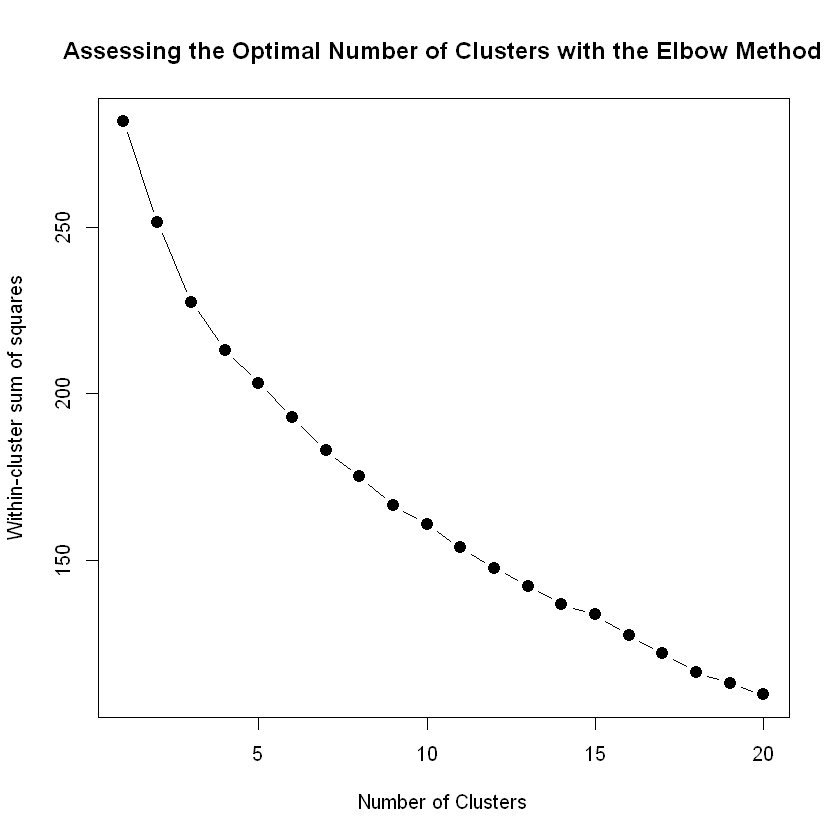

In [20]:
plot(c(1:20), wss, type="b", xlab="Number of Clusters", ylab="Within-cluster sum of squares", main="Assessing the Optimal Number of Clusters with the Elbow Method", pch=20, cex=2)

Unfortunately, there is no clear "elbow" in the plot above to help us select the optimal number of clusters but it seems that the within sum of squares starts decreasing at a slower rate after cluster 6. Since it might be too costly to design targeted offers for too many groups of customers, we may be interested in no more than 6 clusters anyway.

If the data could be largely explained by its first two principal components (which is not the case here as shown above), we could plot the clusters in 2-dimensional space using 3, 4, 5, or 6 clusters and examine which setup results in well separated clusters.   

###  Selecting the optimal number of clusters - the Gap statistic 

A more formal method to determine the optimal number of clusters was developed by Tibshirani et al (2001), which estimates the largest difference (gap) between the log of the observed within sum of squares and the log of the expected sum of squares based on a reference distribution. The optimal number of clusters is given as the smallest k that results in the highest gap that is at least as large as the standard deviation of the gap statistic.

In [21]:
#install.packages("cluster", repo="CRAN")
require(cluster)

Loading required package: cluster


In [22]:
set.seed(14)
gap_stat <- clusGap(wine, FUN = kmeans, nstart = 25, K.max=10, B = 100)

In [23]:
gap_stat
names(gap_stat)

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = wine, FUNcluster = kmeans, K.max = 10, B = 100, nstart = 25)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 9
          logW   E.logW       gap     SE.sim
 [1,] 4.057172 4.523635 0.4664629 0.01082993
 [2,] 3.986771 4.471971 0.4851992 0.01049629
 [3,] 3.919637 4.434967 0.5153297 0.01049935
 [4,] 3.882556 4.403767 0.5212107 0.01086439
 [5,] 3.845563 4.376744 0.5311812 0.01106331
 [6,] 3.811686 4.352015 0.5403291 0.01134528
 [7,] 3.782376 4.328666 0.5462898 0.01166720
 [8,] 3.760647 4.307012 0.5463657 0.01165952
 [9,] 3.727800 4.286166 0.5583663 0.01165111
[10,] 3.702733 4.265891 0.5631577 0.01188131

[1] "Tab"        "call"       "spaceH0"    "n"          "B"         
[6] "FUNcluster"

The default method for determining the optimal number of clusters is the "firstSEmax" - it looks for the smallest number of clusters, k, such that the gap statistic for this k is not more than 1 standard deviation away from the first local maximum. According to this method, the optimal number of clusters is 9, as shown in the output above. 

Does the selection of optimal k depend on the method chosen? We will also implement the clusGap function using the scaled standard deviation measure derived in Tibshirani et al (2001) - it is selected with "Tibs2001SEmax". 

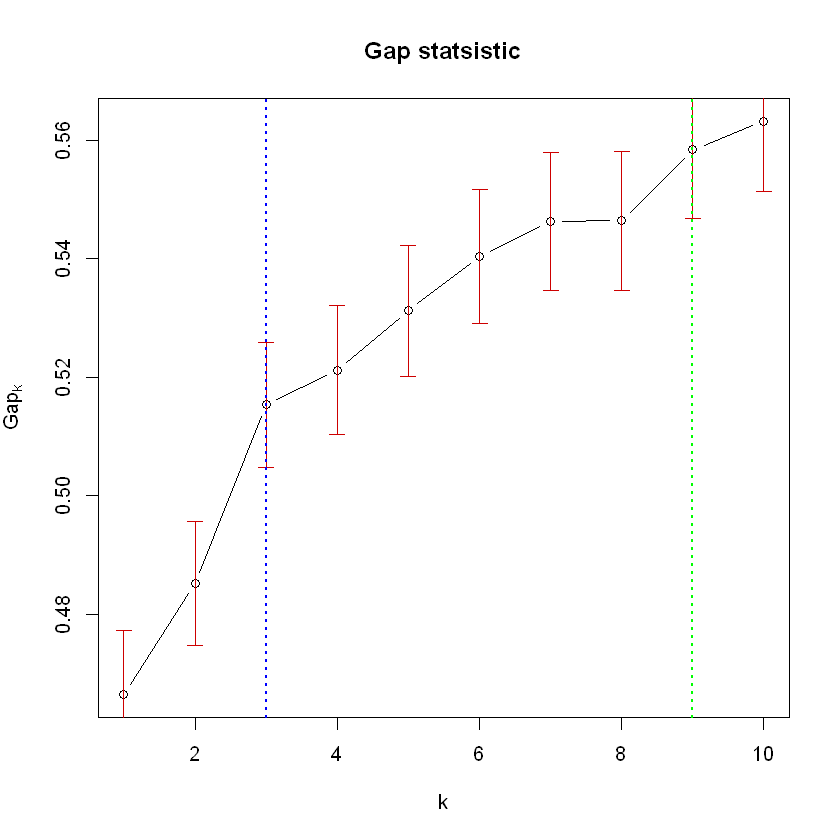

In [24]:
# Plot the gap statistic and optimal number of clusters
k1 <- maxSE(gap_stat$Tab[, "gap"], gap_stat$Tab[, "SE.sim"], method="firstSEmax")
k2 <- maxSE(gap_stat$Tab[, "gap"], gap_stat$Tab[, "SE.sim"], method="Tibs2001SEmax")

plot(gap_stat, main=("Gap statsistic"))
abline(v=k1, lty=3, lwd=2, col="Green")
abline(v=k2, lty=3, lwd=2, col="Blue")

Depending on the choice of method, the optimal number of clusters is indicated as 3 or 9 - this is harldy a consensus. The Elbow method also did not produce a clear cut choice for k. This example illustrates that choosing the optimal number of clusters is tricky, especially when we cannot visualize the observations in a two-dimensional plot. Perhaps the choice of k between 3 and 9 will be ultimately determined by considering the tradeoff between the risk of overspending by choosing a larger number of customer groups and the risk of alienating some customers with irrelevant offers by choosing a smaller number of clusters. 

We will examine the result of one more heuristic - the cluster "silhouette". 

### Selecting the optimal number of clusters - Silhouette analysis

An alternative metric of measuring whether the derived clusters are well defined is called the 'silhouette' - it is measured at the observation level and takes into account not only how close an observation is to its assigned cluster, but also how close it is to the nearest cluster it does not belong to. A silhouette measure ranges from 0 to 1 and is interpreted as follows: 

* Observations with a silhouette value close to 1 are well clustered

* Observations with a silhouette value close to 0 means that the observations lie between two clusters

* Observations with a negative silhouette value are probably placed in the wrong cluster

We will plot the silhouettes of each cluster in two scenarios: k=3 and k=9.

In [25]:
sil_3k <- silhouette(kmeans(wine, 3, nstart=20)$cluster, dist(wine), dist(wine))
head(sil_3k[, 1:3], 10)

cluster,neighbor,sil_width
2,1,0.26269670
3,1,-0.04917952
1,2,0.44202431
2,1,0.21283769
3,2,-0.08089974
3,2,0.03060239
1,2,0.46562313
2,1,0.23343669
3,2,-0.05256629
2,1,0.28661095


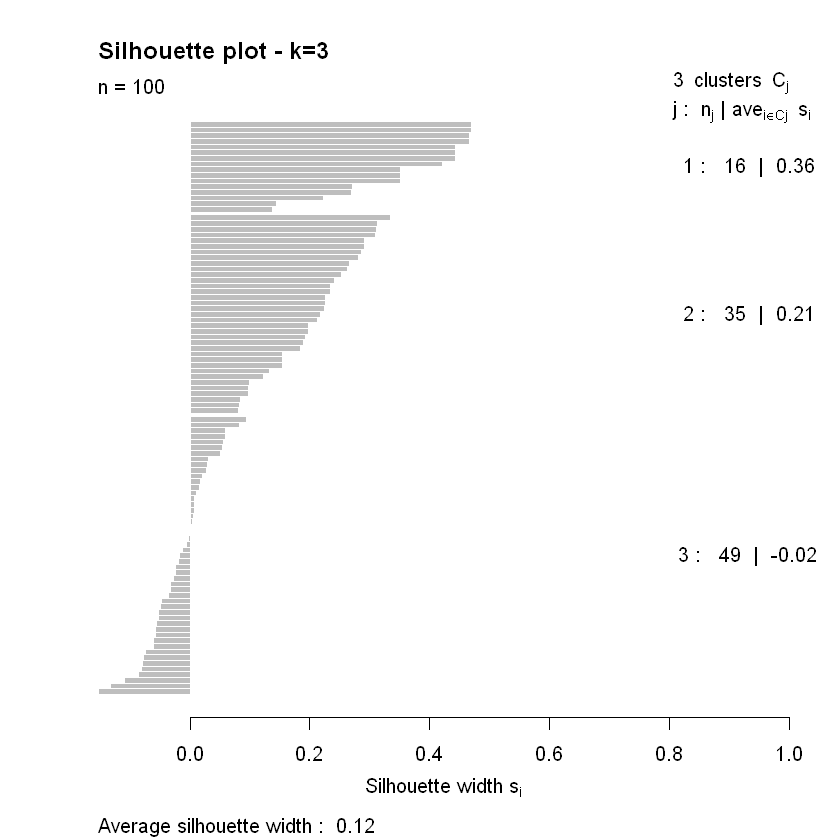

In [26]:
plot(sil_3k, main = "Silhouette plot - k=3")

With three clusters, the silhouette plot clearly indicates that one of the clusters is not well defined - a lot the observations assigned to this cluster have negative silhouettes indicating that they are probably not assigned to the right cluster. In addition, even in the other two clusters, the average silhouette is less than 0.5 indicating that there is a lot of ambiguity in the cluster assignment. 

Next we examine the silhouette plot with 9 clusters. 

cluster,neighbor,sil_width
5,6,0.17057512
8,5,0.02444335
1,5,0.48875092
5,6,0.15381832
3,5,0.05671052
3,7,0.13108968
1,5,0.51153946
6,5,0.21033544
7,6,0.04736467
5,6,0.22023409


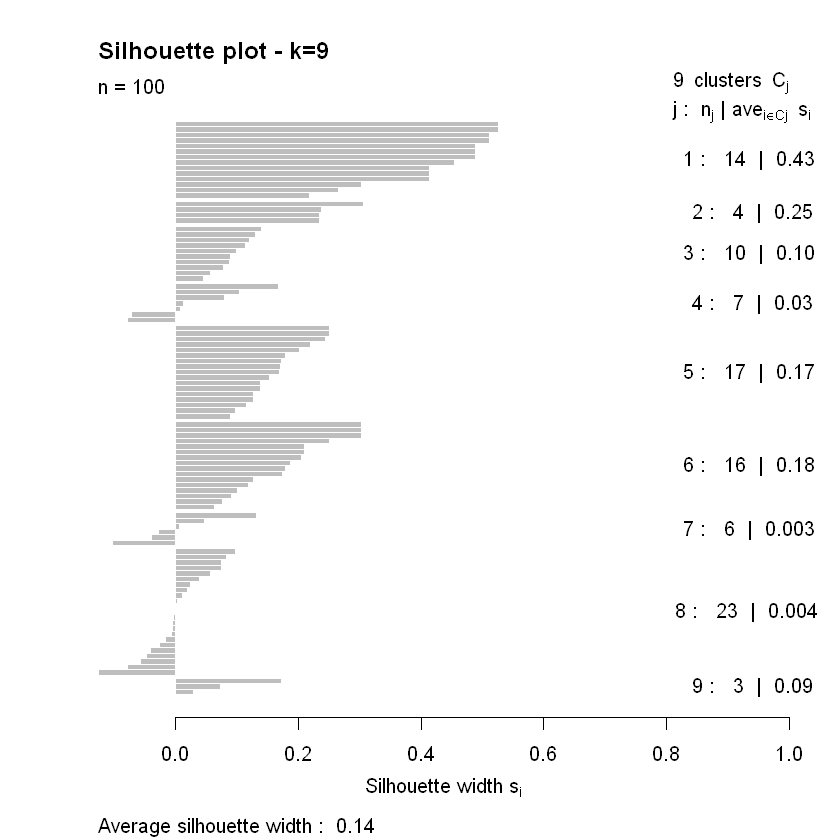

In [27]:
sil_9k <- silhouette(kmeans(wine, 9, nstart=20)$cluster, dist(wine))
head(sil_9k[, 1:3], 10)
plot(sil_9k, main="Silhouette plot - k=9")

The average silhouette with 9 clusters is slightly higher than with 3 clusters. While two of the clusters seem more well defined than in the case with 3 clusters only, the rest of the clusters do not have particularly high silhouettes and suggest that we have not improved significantly on the compactness of the clusters by selecting 9 clusters.  

## Application of spherical K-means

It appears that the poor clustering performance cannot be explained by the selection of the number of clusters. As discussed in the book by John Foreman, "Data Smart," the plain vanilla k-means is not the optimal algorithm for clustering customers based on purchase history. The purchase data is binary with 1 indicating a purchase and 0 otherwise. The fact that a customer made a purchase conveys more information and therefore should carry more weight than the fact that she did not. This property is defined as "null invariance" in Tan, Kumar, and Srivastava (2004), which further explain that null invariant measures like cosine similarity and the Jaccard similarity metric are appropriate for "sparse data sets, where co-presence of items is more important than co-absence. Examples include market-basket data and text documents." In the present case of market basket analysis, two customers who purchased the same product tend to be more similar to each other than two customers who both did not purchase a given product. Therefore, we will proceed with a clustering algorithm that uses *cosine dissimilarity* and is known as *spherical k-means*.

Cosine dissimilarity equals 1 minus cosine similarity, where the latter is defined as the inner product of two observations divided by the product of their L-2 norms (i.e., it is the inner product of two observations normalized by their vector magnitudes). Technically, cosine dissimilarity is not a distance measure because it does not conform to the triangle inequality. However, for non-negative feature vectors the cosine dissimilarity ranges from 0 to 1, with 0 indicating identical observations, thereby one could interpret it in the same way as a distance measure. 

Cosine dissimilarity is also exteremely efficient to calculate for sparse feature vectors because it only needs to consider the non-zero elements of the vectors. For this reason it is commonly used for clustering text documents where the feature vectors are the word counts and they tend to be pretty sparse.

Below we will examine the clusters formed under spherical k-means using 3 clusters. 

In [28]:
# Install package "skmeans"
#options(repos='http://cran.rstudio.com/')
#install.packages("skmeans")

In [29]:
require(skmeans)
wine.m <- as.matrix(wine)

# Method *genetic* specifies that we would like hard partitions as opposed to soft assignments
skm.out <- skmeans(wine.m, 3, method="genetic")
skm.out

Loading required package: skmeans


A hard spherical k-means partition of 100 objects into 3 classes.
Class sizes: 47, 17, 36
Call: skmeans(x = wine.m, k = 3, method = "genetic")

In [30]:
str(skm.out)

List of 7
 $ prototypes: num [1:3, 1:32] 0.1673 0.09 0 0.0678 0.3315 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "1" "2" "3"
  .. ..$ : chr [1:32] "offer1" "offer2" "offer3" "offer4" ...
 $ membership: NULL
 $ cluster   : Named int [1:100] 3 1 2 3 1 1 2 3 1 3 ...
  ..- attr(*, "names")= chr [1:100] "Adams" "Allen" "Anderson" "Bailey" ...
 $ family    :List of 7
  ..$ description: chr "spherical k-means"
  ..$ D          :function (x, prototypes)  
  ..$ C          :function (x, weights, control)  
  ..$ init       :function (x, k)  
  ..$ e          : num 1
  ..$ .modify    : NULL
  ..$ .subset    : NULL
  ..- attr(*, "class")= chr "pclust_family"
 $ m         : num 1
 $ value     : num 45.1
 $ call      : language skmeans(x = wine.m, k = 3, method = "genetic")
 - attr(*, "class")= chr [1:2] "skmeans" "pclust"


Let's examine the output of the *skmeans* function

In [31]:
names(skm.out)

[1] "prototypes" "membership" "cluster"    "family"     "m"         
[6] "value"      "call"

In [32]:
skm.out$prototypes

,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,offer10,...,offer23,offer24,offer25,offer26,offer27,offer28,offer29,offer30,offer31,offer32
1,0.1673020,0.06779343,0.09786051,0.28626,0.1168974,0.24351764,0.06363495,0.06806992,0.2738547,0.09077439,...,0.1019726,0.0000000,0.1444314,0.05411504,0.17966173,0.11986887,0.02161678,0.1123912,0.4355708,0.09223821
2,0.0900197,0.33146720,0.00000000,0.00000,0.0000000,0.00000000,0.00000000,0.00000000,0.0000000,0.03294950,...,0.0329495,0.6199938,0.0000000,0.60903974,0.03294950,0.00000000,0.00000000,0.0000000,0.0000000,0.00000000
3,0.0000000,0.00000000,0.04525240,0.00000,0.0000000,0.02295681,0.43940533,0.49876674,0.0000000,0.04946505,...,0.0000000,0.0000000,0.0000000,0.00000000,0.03246583,0.03246583,0.44210283,0.4566784,0.0000000,0.00000000


*Prototypes* is another name for the cluster centers - here we see the feature vectors associated with each cluster center.

In [33]:
# Cluster assignments
head(skm.out$cluster)

Adams    Allen Anderson   Bailey    Baker   Barnes 
       3        1        2        3        1        1

In [34]:
# The minimum value achieved for the objective function
skm.out$value

[1] 45.14159

We can also output another common measure of evaluating the performance of the clustering - "dissimilarity accounted for," which equals average dissimilarity over total dissimilarity. 

In [35]:
require(clue)
cl_validity(skm.out)

Loading required package: clue


Dissimilarity accounted for: 0.1734369

Let's examine one of the clusters to see if we pick up the same or stronger patterns as in the clusters identified by regular k-means. 

In [36]:
df.prototypes <- data.frame(t(skm.out$prototype))
colnames(df.prototypes) <- paste0("cluster", c(1:3))
head(df.prototypes[order(-df.prototypes[1]), ], 10)

,cluster1,cluster2,cluster3
offer22,0.4771356,0.0000000,0.01874416
offer31,0.4355708,0.0000000,0.00000000
offer4,0.2862600,0.0000000,0.00000000
offer11,0.2814637,0.0000000,0.03246583
offer9,0.2738547,0.0000000,0.00000000
offer6,0.2435176,0.0000000,0.02295681
offer14,0.2224911,0.0000000,0.00000000
offer27,0.1796617,0.0329495,0.03246583
offer1,0.1673020,0.0900197,0.00000000
offer25,0.1444314,0.0000000,0.00000000


In cluster 1 we see that the dominant offers are 8, 30, 29, 7, 18, and 13. These are the same dominant offers that we saw in cluster 4 of the k-means output - the low-volume, high-discount buyers. 

Did the spherical k-means algorithm achieve better separation of the clusters? We will look at the silhouettes again to examine this. 

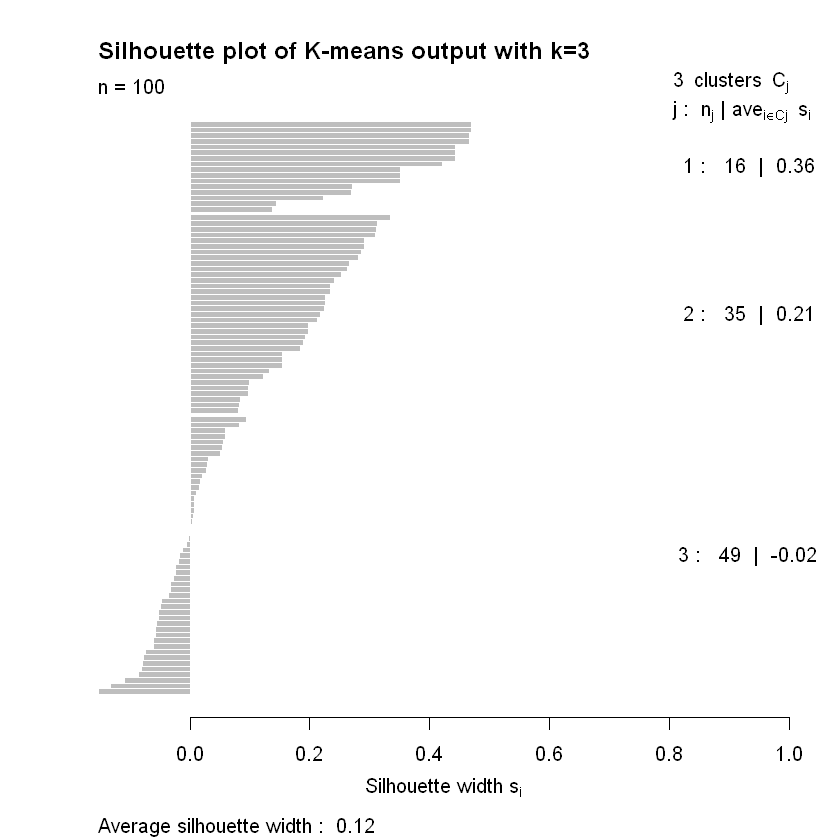

In [37]:
# Plot the k-means silhouette with k=3
plot(sil_3k, main = "Silhouette plot of K-means output with k=3")

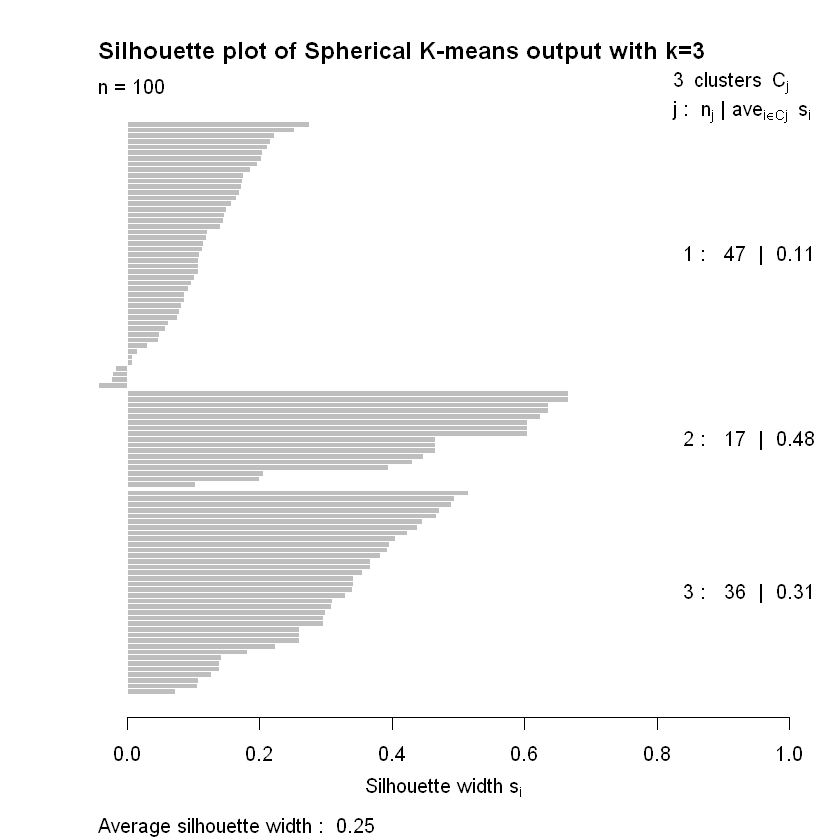

In [38]:
# Plot the spherical k-means silhouette with k=3
plot(silhouette(skm.out), main="Silhouette plot of Spherical K-means output with k=3")

We see a marked improvement of the individual cluster silhouettes in the spherical k-means output. All clusters have a positive average silhouette measure and the average silhouette is 0.25 with spherical k-means vs. 0.12 with k-means. A silhouette of 0.25 is still not stellar because ideally we are looking for a clustering outcome that produces a silhouette value close to 1. 

Finally, we will look at the silhouette measure if using soft partitioning by calling the "fixed point" method of the *skmeans* function and specifying the softness parameter *m*.

In [39]:
skm_fp.out <- skmeans(wine.m, 3, m=1.5, method="pclust", control=list(nruns=15))
skm_fp.out

A soft spherical k-means partition (degree m = 1.500000) of 100 objects
into 3 classes.
Class sizes of closest hard partition: 47, 36, 17.
Call: skmeans(x = wine.m, k = 3, method = "pclust", m = 1.5, control = list(nruns = 15))

In [40]:
cl_validity(skm_fp.out)

Dissimilarity accounted for: 0.07820545

The dissimilarity accounted for is actually much lower than with the hard partitioning. 

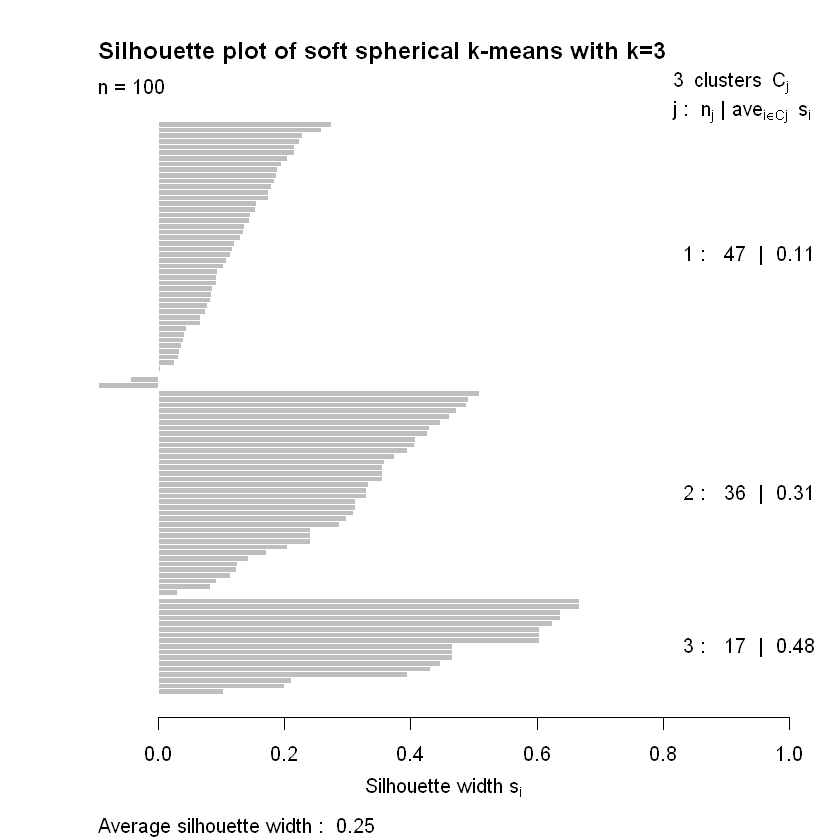

In [41]:
plot(silhouette(skm_fp.out), main="Silhouette plot of soft spherical k-means with k=3")

Applying soft partitioning did not improve the silhouette of the clusters, suggesting no improvement over the hard partitions.